In [1]:
# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size
 
# output layer 1x1 pixel with 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)
# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)
# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


In [2]:
# example of defining a composite model for training the generator model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image #Esto permite manipular imagenes

import tensorflow as tf
import tensorflow.keras as kr

import matplotlib.pyplot as plt
import numpy as np

import math
import random

Using TensorFlow backend.


In [3]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [4]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [5]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [6]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [8]:
# define image shape
image_shape = (256,256,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model_2[1][0]                    
Total params: 61,397,

In [9]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	#ix = random.randint(0, trainA.shape[0], n_samples)
	ix = random.randint(0, trainA.shape[0])
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [10]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [11]:

# select a batch of real samples
#[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)


# generate a batch of fake samples
#X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

In [12]:

# update discriminator for real samples
#d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
#d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

In [13]:

# update the generator
#g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])



In [48]:
#Esto hace lo mismo que los 3 bloques anteriores
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=16, n_batch=1, n_patch=16):
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	#n_steps = n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

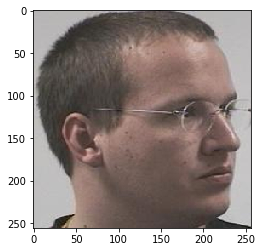

In [15]:
x = image.load_img('D:\github\dataset_train\input\Foto (3).bmp', target_size=(256,256)) #Cargo la imagen y la reshapeo a 299x299 para que sea compatible
#con la red neuronal que pide ese tamaño de entrada
x = image.img_to_array(x) #La convierto en matriz

x = (x/255.)

plt.imshow(x)


In [18]:
#CARGO TODAS LAS IMAGENES DEL DATASET 

x = (np.zeros(182*1*256*256*3)).reshape(182,1,256,256,3)
y = (np.zeros(182*1*256*256*3)).reshape(182,1,256,256,3)

i = 0
for i in range(182):
    i = i + 1
    path = r"D:\github\dataset_train\input\Foto (" + str(i) + ").bmp"
    aux = image.load_img(path, target_size=(256,256))
    x[i-1] =  image.img_to_array(aux)
    path = r"D:\github\dataset_train\output\Foto (" + str(i) + ").bmp"
    aux = image.load_img(path, target_size=(256,256))
    y[i-1] =  image.img_to_array(aux)    

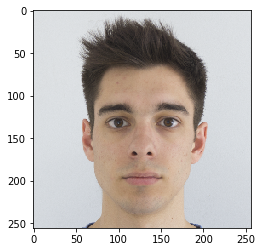

In [45]:
#para verificacion

#pepe = x[181][0]/255.
pepe = image.load_img('.\DSC02185.png', target_size=(256,256))
pepe = image.img_to_array(pepe)
pepe = pepe/255.
plt.imshow(pepe)

In [39]:
# load image data
dataset = x,y
# train model
train(d_model, g_model, gan_model, dataset)
g_model.save('modelo')
g_model.save_weights('first_try.h5')

D:\Programas\AnacondaFinal\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1[0.002] d2[0.002] g[9935.418]
>2, d1[0.003] d2[0.002] g[9998.804]
>3, d1[0.003] d2[0.003] g[8234.753]
>4, d1[0.004] d2[0.003] g[12813.741]
>5, d1[0.002] d2[0.003] g[9521.872]
>6, d1[0.004] d2[0.004] g[9999.433]
>7, d1[0.002] d2[0.002] g[10413.920]
>8, d1[0.002] d2[0.002] g[11401.782]
>9, d1[0.002] d2[0.002] g[12044.479]
>10, d1[0.002] d2[0.002] g[10280.144]
>11, d1[0.002] d2[0.002] g[10481.686]
>12, d1[0.001] d2[0.002] g[10208.860]
>13, d1[0.003] d2[0.003] g[9075.692]
>14, d1[0.003] d2[0.003] g[12901.119]
>15, d1[0.002] d2[0.001] g[9205.917]
>16, d1[0.002] d2[0.002] g[9888.837]
>17, d1[0.002] d2[0.002] g[8579.475]
>18, d1[0.003] d2[0.002] g[8356.021]
>19, d1[0.002] d2[0.002] g[10285.968]
>20, d1[0.002] d2[0.002] g[9519.486]
>21, d1[0.002] d2[0.002] g[11121.814]
>22, d1[0.002] d2[0.002] g[11638.215]
>23, d1[0.001] d2[0.002] g[10483.404]
>24, d1[0.002] d2[0.002] g[10901.924]
>25, d1[0.001] d2[0.002] g[11844.958]
>26, d1[0.002] d2[0.002] g[8356.602]
>27, d1[0.001] d2[0.001] g[9891.1

>216, d1[0.000] d2[0.000] g[10648.485]
>217, d1[0.000] d2[0.000] g[10207.692]
>218, d1[0.001] d2[0.001] g[12705.202]
>219, d1[0.001] d2[0.001] g[8583.175]
>220, d1[0.001] d2[0.001] g[10166.259]
>221, d1[0.001] d2[0.000] g[12931.983]
>222, d1[0.000] d2[0.000] g[11676.900]
>223, d1[0.000] d2[0.000] g[10306.486]
>224, d1[0.000] d2[0.001] g[9349.642]
>225, d1[0.000] d2[0.000] g[11206.385]
>226, d1[0.001] d2[0.001] g[8227.501]
>227, d1[0.000] d2[0.001] g[11601.105]
>228, d1[0.001] d2[0.001] g[9267.377]
>229, d1[0.000] d2[0.000] g[10831.464]
>230, d1[0.000] d2[0.001] g[9718.246]
>231, d1[0.001] d2[0.001] g[12898.557]
>232, d1[0.000] d2[0.001] g[9716.483]
>233, d1[0.000] d2[0.000] g[11514.591]
>234, d1[0.000] d2[0.000] g[10934.095]
>235, d1[0.000] d2[0.000] g[10643.101]
>236, d1[0.001] d2[0.001] g[10163.877]
>237, d1[0.000] d2[0.000] g[10572.946]
>238, d1[0.000] d2[0.000] g[9871.331]
>239, d1[0.001] d2[0.001] g[8227.223]
>240, d1[0.000] d2[0.000] g[9672.945]
>241, d1[0.000] d2[0.000] g[10518.

KeyboardInterrupt: 

In [46]:
pepe2 = g_model.predict(pepe.reshape(1,256,256,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


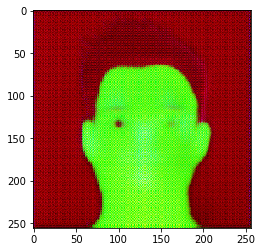

In [47]:
plt.imshow(pepe2.reshape(256,256,3))